# Pre-Processing & Modelling

We are here! We are finally here! I'm ready to build a model to predict SPI scores based on transfer spending data, after some pre-processing.

__What's Happened So Far:__
 - Found data to use. View it here.
 - Cleaned the transfers data. Notebook
 - Cleaned the SPI data. Notebook
 - Learned how to create new features!
 - Visualized the new features and looked at correlations. Notebook

Now, the moment of truth. 

As always, first steps are reading in the data and import libraries.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
path = '/home/tdraths/sb_assignments/Transfers_Capstone/data/data_cleaning_outputs/SPI_Transfers_Features.csv'
df = pd.read_csv(path, index_col=0)
pd.set_option('display.max_columns', None)
display(df.shape)
df.sample(5)

(100, 26)

,Year,Team,Team Name,Total Transfers (In),Total Transfers (Out),Total Spent (In),Total Earned (Out),Average Fee (In),Max Fee Spent,Min Fee Spent,Average Home SPI Score,Average Away SPI Score,Average Season SPI Score,Most Purchased Position,Position Max Spend,Position Min Spend,Average Spent on Goalkeeper,Average Spent on Left-Back,Average Spent on Right-Back,Average Spent on Centre-Back,Average Spent on Defensive Midfielder,Average Spent on Left Winger,Average Spent on Attacking Midfielder,Average Spent on Right Winger,Average Spent on Striker,spi_diffs
19,2016,WHU,West Ham United,20,16,75150000.0,36900000.0,3.757500e+06,21690000.0,26370000.0,61.657895,61.418421,61.54,Striker,Attacking Midfielder,Centre-Back,0.0,3.195000e+06,0.0,2070000.0,0.0,21690000.0,5520000.0,4500000.0,2182500.0,1.875
73,2019,NOR,Norwich City,21,26,6440000.0,0.0,3.066667e+05,3740000.0,0.0,60.261579,59.871579,60.07,Striker,Left-Back,Striker,2700000.0,1.246667e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
4,2016,CRY,Crystal Palace,22,25,91170000.0,45180000.0,4.144091e+06,28080000.0,26010000.0,58.646842,58.364737,58.51,Striker,Striker,Centre-Back,0.0,9.450000e+06,0.0,4200000.0,3397500.0,2484000.0,0.0,14040000.0,5814000.0,2.775
55,2018,SOU,Southampton,16,18,56030000.0,21420000.0,3.501875e+06,22500000.0,10710000.0,66.577368,66.521053,66.55,Attacking Midfielder,Centre-Back,Goalkeeper,10170000.0,0.000000e+00,0.0,11250000.0,0.0,16200000.0,1432000.0,0.0,0.0,5.960
25,2017,CRY,Crystal Palace,16,18,44060000.0,2700000.0,2.753750e+06,25380000.0,2700000.0,60.082632,59.823684,59.95,Centre-Back,Centre-Back,Attacking Midfielder,0.0,0.000000e+00,0.0,7192000.0,0.0,0.0,0.0,0.0,4050000.0,1.440


In [3]:
display(df['Most Purchased Position'].value_counts())
display(df['Position Max Spend'].value_counts())
display(df['Position Min Spend'].value_counts())

Striker                 38
Attacking Midfielder    24
Centre-Back             13
Goalkeeper              10
Right Winger             7
Right-Back               4
Left Winger              2
Defensive Midfielder     1
Left-Back                1
Name: Most Purchased Position, dtype: int64

Striker                 24
Attacking Midfielder    20
Centre-Back             15
Left Winger             15
Right Winger            10
Defensive Midfielder     9
Left-Back                3
Right-Back               2
Goalkeeper               2
Name: Position Max Spend, dtype: int64

Striker                 20
Attacking Midfielder    17
Centre-Back             15
Right-Back              12
Goalkeeper               9
Defensive Midfielder     7
Right Winger             7
Left-Back                7
Left Winger              6
Name: Position Min Spend, dtype: int64

In [4]:
map_most_purchased = {
    'Right-Back': 'Other',
    'Left Winger': 'Other',
    'Defensive Midfielder': 'Other',
    'Left-Back': 'Other',
}

map_max_spend = {
    'Defensive Midfielder': 'Other',
    'Left-Back': 'Other',
    'Right-Back': 'Other',
    'Goalkeeper': 'Other'
}

map_min_spend = {
    'Left-Back': 'Other',
    'Right Winger': 'Other',
    'Defensive Midfielder': 'Other',
    'Left Winger': 'Other'
}

df['Most Purchased Position'] = df['Most Purchased Position'].replace(map_most_purchased)
df['Position Max Spend'] = df['Position Max Spend'].replace(map_max_spend)
df['Position Min Spend'] = df['Position Min Spend'].replace(map_min_spend)

display(df['Most Purchased Position'].value_counts())
display(df['Position Max Spend'].value_counts())
display(df['Position Min Spend'].value_counts())

Striker                 38
Attacking Midfielder    24
Centre-Back             13
Goalkeeper              10
Other                    8
Right Winger             7
Name: Most Purchased Position, dtype: int64

Striker                 24
Attacking Midfielder    20
Other                   16
Centre-Back             15
Left Winger             15
Right Winger            10
Name: Position Max Spend, dtype: int64

Other                   27
Striker                 20
Attacking Midfielder    17
Centre-Back             15
Right-Back              12
Goalkeeper               9
Name: Position Min Spend, dtype: int64

## Dummies for Days
Some of my new features are categorical, and describe the positions a team bought the most of, spent the most on and spent the least on, respectively. You can see these in `Most Purchased Position`, `Position Max Spend`, `Position Min Spend`.

Below, I define those columns in a list and then create a dataframe with my current `df` and the new dummy features. I'm surprised by how easy this is.

In [5]:
columns = ['Most Purchased Position', 'Position Max Spend', 'Position Min Spend']
df_dummies = pd.get_dummies(df, columns=columns)
display(df_dummies.shape)
df_dummies.sample()

(100, 41)

,Year,Team,Team Name,Total Transfers (In),Total Transfers (Out),Total Spent (In),Total Earned (Out),Average Fee (In),Max Fee Spent,Min Fee Spent,Average Home SPI Score,Average Away SPI Score,Average Season SPI Score,Average Spent on Goalkeeper,Average Spent on Left-Back,Average Spent on Right-Back,Average Spent on Centre-Back,Average Spent on Defensive Midfielder,Average Spent on Left Winger,Average Spent on Attacking Midfielder,Average Spent on Right Winger,Average Spent on Striker,spi_diffs,Most Purchased Position_Attacking Midfielder,Most Purchased Position_Centre-Back,Most Purchased Position_Goalkeeper,Most Purchased Position_Other,Most Purchased Position_Right Winger,Most Purchased Position_Striker,Position Max Spend_Attacking Midfielder,Position Max Spend_Centre-Back,Position Max Spend_Left Winger,Position Max Spend_Other,Position Max Spend_Right Winger,Position Max Spend_Striker,Position Min Spend_Attacking Midfielder,Position Min Spend_Centre-Back,Position Min Spend_Goalkeeper,Position Min Spend_Other,Position Min Spend_Right-Back,Position Min Spend_Striker
82,2020,BHA,Brighton and Hove Albion,25,18,21150000.0,18540000.0,846000.0,9900000.0,10530000.0,70.142632,70.165263,70.15,0.0,4950000.0,0.0,337500.0,0.0,0.0,1980000.0,0.0,600000.0,1.39,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [6]:
data = df_dummies.drop(columns=['Year', 'Team', 'Team Name'])

## II. Plotting feature distributions

#### Distributions of a few select features
The statistics above show that the features are on different scales. For example:
 - `Average Season SPI Score`:
      - Min: 47.33
      - Max: 94.88
      - Mean: 70.08
 - `Total Transfers (In)`:
      - Min: 4.0
      - Max: 39.0
      - Mean: 17.19
 - `Total Spent (In)`:
      - Min: 0.00
      - Max: 2.85 e+08
      - Mean: 7.83 e+07   
 

I'll visualize distributions for a few of the columns below.

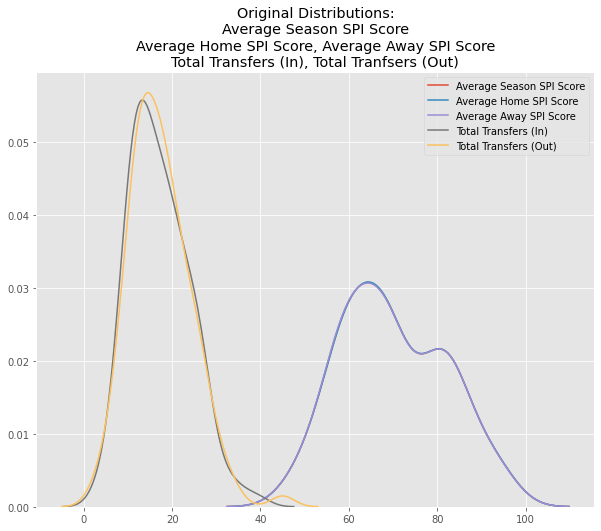

In [7]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title(
    "Original Distributions:\nAverage Season SPI Score\nAverage Home SPI Score, Average Away SPI Score\nTotal Transfers (In), Total Tranfsers (Out)")

sns.kdeplot(data['Average Season SPI Score'], ax=ax1)
sns.kdeplot(data['Average Home SPI Score'], ax=ax1)
sns.kdeplot(data['Average Away SPI Score'], ax=ax1)

sns.kdeplot(data['Total Transfers (In)'], ax=ax1)
sns.kdeplot(data['Total Transfers (Out)'], ax=ax1);

In the KDE Plot above, there are two distinct distributions, the left one representing the Total Transfer counts for clubs, and the right one showing the Average SPI Scores for clubs.

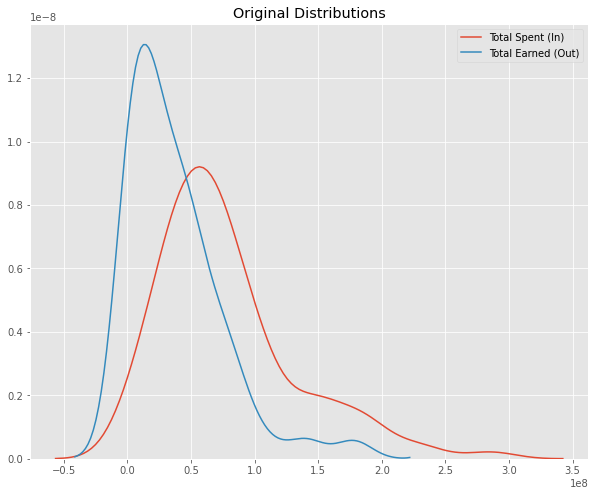

In [8]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

sns.kdeplot(data['Total Spent (In)'], ax=ax1)
sns.kdeplot(data['Total Earned (Out)'], ax=ax1);

In [9]:
X = data.drop(columns=['Average Season SPI Score'])
y = data['Average Season SPI Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In the KDE Plot above, Total Spent and Total Earned are on a completely difference scale from the previous plots. If I put them all together on the same axes, you'd see one straight vertical line near x=0. You can see that at the end of this section.

## III. Trying Different Scalers
I'm new to this, and I'm not sure whether MinMax, RobustScaler, StandardScaler or another method is best for my data. In this section, I'm going to attempt MinMax, Robust and Standard and see which seems to make the most sense. In the cells below, I'll scale the X_train data and visualize the distribution of the scaled data. I'll also scale the X_test data for use later.

#### MinMaxScaler
 - Subtracts the column mean from each value and then divides by the column range.

In [10]:
col_names = list(X_train.columns) # Will to use this list later in scaled DataFrames
col_names

['Total Transfers (In)',
 'Total Transfers (Out)',
 'Total Spent (In)',
 'Total Earned (Out)',
 'Average Fee (In)',
 'Max Fee Spent',
 'Min Fee Spent',
 'Average Home SPI Score',
 'Average Away SPI Score',
 'Average Spent on Goalkeeper',
 'Average Spent on Left-Back',
 'Average Spent on Right-Back',
 'Average Spent on Centre-Back',
 'Average Spent on Defensive Midfielder',
 'Average Spent on Left Winger',
 'Average Spent on Attacking Midfielder',
 'Average Spent on Right Winger',
 'Average Spent on Striker',
 'spi_diffs',
 'Most Purchased Position_Attacking Midfielder',
 'Most Purchased Position_Centre-Back',
 'Most Purchased Position_Goalkeeper',
 'Most Purchased Position_Other',
 'Most Purchased Position_Right Winger',
 'Most Purchased Position_Striker',
 'Position Max Spend_Attacking Midfielder',
 'Position Max Spend_Centre-Back',
 'Position Max Spend_Left Winger',
 'Position Max Spend_Other',
 'Position Max Spend_Right Winger',
 'Position Max Spend_Striker',
 'Position Min Spend_At

In [11]:
mm_scaler = preprocessing.MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_train_mm = pd.DataFrame(X_train_mm, columns=col_names)


X_test_mm = mm_scaler.transform(X_test)

#### RobustScaler
 - Subtracts the column median from each value and then divides by the column interquartile range.

In [12]:
r_scaler = preprocessing.RobustScaler()
X_train_r = r_scaler.fit_transform(X_train)
X_train_r = pd.DataFrame(X_train_r, columns=col_names)

X_test_r = r_scaler.transform(X_test)

#### StandardScaler
 - Scales each column to unit variance by removing the mean.

In [13]:
s_scaler = preprocessing.StandardScaler()
X_train_s = s_scaler.fit_transform(X_train)
X_train_s = pd.DataFrame(X_train_s, columns=col_names)

X_test_s = s_scaler.transform(X_test)

## IV. Putting it all together

Now that I've scaled the data, it's time to decide which method I'll use in my model. I've plotted the distributions of the original data of the three versions of scaled data below, using a few select columns.
 - `Average Home SPI Score`, `Average Away SPI Score`
 - `Total Transfers (In)`, `Total Transfers (Out)`
 - `Total Spent (In)`, `Total Earned (Out)`



In [14]:
# n_scaler = preprocessing.Normalizer()
# df_n = n_scaler.fit_transform(df_dummies)

# df_n = pd.DataFrame(df_n, columns=col_names)

# fig, (ax1) = plt.subplots(ncols=1, figsize=(10,8))
# ax1.set_title('After Normalizer')

# sns.kdeplot(df_n['Average Season SPI Score'], ax=ax1)
# sns.kdeplot(df_n['Average Home SPI Score'], ax=ax1)
# sns.kdeplot(df_n['Average Away SPI Score'], ax=ax1)
# sns.kdeplot(df_n['Total Transfers (In)'], ax=ax1)
# sns.kdeplot(df_n['Total Transfers (Out)'], ax=ax1)
# sns.kdeplot(df_n['Total Spent (In)'], ax=ax1)
# sns.kdeplot(df_n['Total Earned (Out)'], ax=ax1);

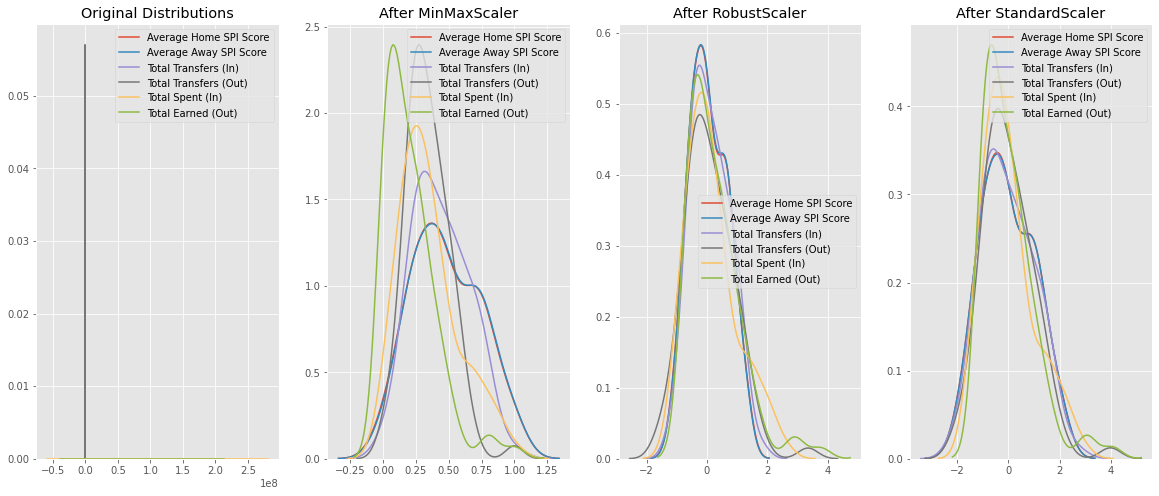

In [15]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(20,8))

ax0.set_title('Original Distributions')
#sns.kdeplot(X_train['Average Season SPI Score'], ax=ax0)
sns.kdeplot(X_train['Average Home SPI Score'], ax=ax0)
sns.kdeplot(X_train['Average Away SPI Score'], ax=ax0)
sns.kdeplot(X_train['Total Transfers (In)'], ax=ax0)
sns.kdeplot(X_train['Total Transfers (Out)'], ax=ax0)
sns.kdeplot(X_train['Total Spent (In)'], ax=ax0)
sns.kdeplot(X_train['Total Earned (Out)'], ax=ax0);


ax1.set_title('After MinMaxScaler')
#sns.kdeplot(X_train_mm['Average Season SPI Score'], ax=ax1)
sns.kdeplot(X_train_mm['Average Home SPI Score'], ax=ax1)
sns.kdeplot(X_train_mm['Average Away SPI Score'], ax=ax1)
sns.kdeplot(X_train_mm['Total Transfers (In)'], ax=ax1)
sns.kdeplot(X_train_mm['Total Transfers (Out)'], ax=ax1)
sns.kdeplot(X_train_mm['Total Spent (In)'], ax=ax1)
sns.kdeplot(X_train_mm['Total Earned (Out)'], ax=ax1);


ax2.set_title('After RobustScaler')
#sns.kdeplot(X_train_r['Average Season SPI Score'], ax=ax2)
sns.kdeplot(X_train_r['Average Home SPI Score'], ax=ax2)
sns.kdeplot(X_train_r['Average Away SPI Score'], ax=ax2)
sns.kdeplot(X_train_r['Total Transfers (In)'], ax=ax2)
sns.kdeplot(X_train_r['Total Transfers (Out)'], ax=ax2)
sns.kdeplot(X_train_r['Total Spent (In)'], ax=ax2)
sns.kdeplot(X_train_r['Total Earned (Out)'], ax=ax2);


ax3.set_title('After StandardScaler')
#sns.kdeplot(X_train_s['Average Season SPI Score'], ax=ax3)
sns.kdeplot(X_train_s['Average Home SPI Score'], ax=ax3)
sns.kdeplot(X_train_s['Average Away SPI Score'], ax=ax3)
sns.kdeplot(X_train_s['Total Transfers (In)'], ax=ax3)
sns.kdeplot(X_train_s['Total Transfers (Out)'], ax=ax3)
sns.kdeplot(X_train_s['Total Spent (In)'], ax=ax3)
sns.kdeplot(X_train_s['Total Earned (Out)'], ax=ax3);


In [16]:
X_train = X_train_mm
X_test = X_test_mm

## V. The Academy - Training Algorithms

As I mentioned above, I'm new to this, so I'm going to try as many algorithms as I can to model predictions based on my SPI/Transfers data. I've split the data into X/Y Train/Test sets and I have scaled `X_train` and `X_test` using a MinMax scaler. Now, I'll work through a process to fit and predict using as many algorithms as I can!

### Linear Regression - OLS & NNLS

In [17]:
from sklearn import linear_model
from sklearn.metrics import r2_score, median_absolute_error, accuracy_score

model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
model.fit(X_train, y_train)
print('Coeffcients:', model.coef_)
print('Intercept:', model.intercept_)

Coeffcients: [-7.82887684e-03  3.50188002e-03  1.27047235e-02  3.35848843e-03
 -8.63302531e-03 -3.93466752e-03  9.43377690e-04  2.36826867e+01
  2.38618094e+01  5.74393786e-04  6.28237879e-05 -1.40710277e-03
 -3.82447748e-03  3.39517132e-03 -3.69237887e-04 -2.24958860e-03
 -2.19999738e-03 -8.28323603e-04 -3.54650725e-04  1.05003427e-03
  4.91450674e-04 -1.14013165e-04  4.61364428e-04 -1.19276501e-03
 -6.96071199e-04 -1.16257133e-04 -4.35861752e-04 -9.04778145e-04
 -7.39577404e-05  1.24775086e-03  2.83103909e-04 -1.82278394e-03
  1.30629387e-03 -2.04932318e-04  8.38387099e-05  1.34050970e-04
  5.03532701e-04]
Intercept: 47.33381048441259


In [18]:
y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.9999997954095579

In [19]:

reg_nnls = linear_model.LinearRegression(fit_intercept=True, positive=True)
y_pred_nnls = reg_nnls.fit(X_train, y_train).predict(X_test)
r2_score_nnls = r2_score(y_test, y_pred_nnls)
mae = median_absolute_error(y_test, y_pred_nnls)

print("NNLS R2 Score:", r2_score_nnls)
print('NNLS MAE:', mae)

NNLS R2 Score: 0.9999998950735326
NNLS MAE: 0.0024227333908939386


In [20]:
reg_ols = linear_model.LinearRegression(fit_intercept=True)
y_pred_ols = reg_ols.fit(X_train, y_train).predict(X_test)
r2_score_ols = r2_score(y_test, y_pred_ols)
mae = median_absolute_error(y_test, y_pred_ols)
print("OLS R2 Score:", r2_score_ols)
print("OSL MAE:", mae)

OLS R2 Score: 0.9999997954095579
OSL MAE: 0.0028068555519027427


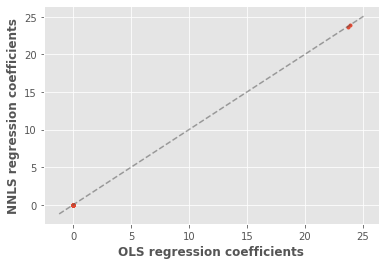

In [21]:
fig, ax = plt.subplots()
ax.plot(reg_ols.coef_, reg_nnls.coef_, linewidth=0, marker='.')

low_x, high_x = ax.get_xlim()
low_y, high_y = ax.get_ylim()
low = max(low_x, low_y)
high = min(high_x, high_y)
ax.plot([low, high], [low, high], ls='--', c='.3', alpha=.5)
ax.set_xlabel('OLS regression coefficients', fontweight='bold')
ax.set_ylabel('NNLS regression coefficients', fontweight='bold');

### ElasticNet

In [22]:
elastic_net = linear_model.ElasticNet(random_state=0)
y_pred = elastic_net.fit(X_train, y_train).predict(X_test)

print(elastic_net.coef_)
print(elastic_net.intercept_)

elastic_net.score(X_test, y_test)

[-0.         -0.          0.98692356  0.54472697  0.70949821  1.46285313
  0.3219248   3.79477009  3.78128062  0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.0282864   0.          0.          0.          0.
 -0.73515996 -0.          0.          0.          0.88011759 -0.
 -0.35326146  0.          0.          0.         -0.83005532  0.
  0.        ]
65.808752140814


0.395948893131568

### LARS

In [23]:
reg = linear_model.Lars(n_nonzero_coefs=1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
reg.score(X_test, y_test)

0.0046400420803832665

### Bayesian Ridge Regression

In [24]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
reg.score(X_test, y_test)

0.9999997953732565

### Support Vector Regression

In [25]:
X_spi = data.drop(columns=['spi_diffs'])
y_spi = data['spi_diffs']

spi_X_train, spi_X_test, spi_y_train, spi_y_test = train_test_split(X_spi, y_spi, test_size=0.2, random_state=0)

In [26]:
from sklearn import svm

regr_avg_score = svm.SVR()
regr_spi_diffs = svm.SVR()

regr_avg_score.fit(X_train, y_train)
regr_spi_diffs.fit(spi_X_train, spi_y_train)

y_avg_score_pred = regr_avg_score.predict(X_test)
y_spi_diffs_pred = regr_spi_diffs.predict(spi_X_test)

print(regr_avg_score.score(X_test, y_test))
print(regr_spi_diffs.score(spi_X_test, spi_y_test))

0.2239048818537751
-0.03136354931104379


### Gaussian Process Regressor

In [27]:
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

#kernel = DotProduct() + WhiteKernel()

gpr_avg_score = gpr(random_state=0, normalize_y=True).fit(X_train, y_train)
gpr_spi_diffs = gpr(random_state=0, normalize_y=True).fit(spi_X_train, spi_y_train)

y_avg_score_pred = gpr_avg_score.predict(X_test)
y_spi_diffs_pred = gpr_spi_diffs.predict(spi_X_test)

print(gpr_avg_score.score(X_test, y_test))
print(gpr_spi_diffs.score(spi_X_test, spi_y_test))

0.6257763906496161
-0.15508370369321245


### Partial Least Squares Regressor

In [28]:
from sklearn.cross_decomposition import PLSRegression as pls2

pls_avg_score = pls2().fit(X_train, y_train)
pls_spi_diffs = pls2().fit(spi_X_train, spi_y_train)

y_avg_score_pred = pls_avg_score.predict(X_test)
y_spi_diffs_pred = pls_spi_diffs.predict(spi_X_test)



print(pls_avg_score.score(X_test, y_test))
print(pls_spi_diffs.score(spi_X_test, spi_y_test))

0.9329378000018989
-0.6153756212315422


### Partial Least Squares Canonical 

In [29]:
from sklearn.cross_decomposition import PLSCanonical as plsca
plsca_avg_score = plsca().fit(X_train, y_train)
plsca_spi_diffs = plsca().fit(spi_X_train, spi_y_train)
y_avg_score_pred = plsca_avg_score.predict(X_test)
y_spi_diffs_pred = plsca_spi_diffs.predict(spi_X_test)

print(plsca_avg_score.score(X_test, y_test))
print(plsca_spi_diffs.score(spi_X_test, spi_y_test))

-1.6995168879261549
-2.0662757335861626


### Decision Tree Regression

In [30]:
from sklearn.tree import DecisionTreeRegressor

clf_avg_score = DecisionTreeRegressor().fit(X_train, y_train)
clf_spi_diffs = DecisionTreeRegressor().fit(spi_X_train, spi_y_train)

y_avg_score_pred = clf_avg_score.predict(X_test)
y_spi_diffs_pred = clf_spi_diffs.predict(spi_X_test)

print(clf_avg_score.score(X_test, y_test))
print(clf_spi_diffs.score(spi_X_test, spi_y_test))

0.9822448495956819
-0.9071631135016993


In [31]:
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=8)

regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)
regr_3.fit(X_train, y_train)

pred_1 = regr_1.predict(X_test)
pred_2 = regr_2.predict(X_test)
pred_3 = regr_3.predict(X_test)

print(pred_1)

[56.77038462 81.58565217 56.77038462 68.0416     68.0416     68.0416
 81.58565217 56.77038462 68.0416     68.0416     81.58565217 81.58565217
 68.0416     56.77038462 68.0416     93.07       56.77038462 81.58565217
 56.77038462 81.58565217]
